In [11]:
import os
from pyspark import SparkContext
from pyspark.sql import SparkSession
import findspark
import numpy as np
import pyspark
findspark.init()

In [29]:
spark.sparkContext.setLogLevel("ERROR")

In [2]:
def readFile(filename):
    """
    Return an RDD containing the data of filename.
    Each example (row) of the file corresponds to one RDD record.
    Each record of the RDD is a tuple (X,y). “X” is an array containing the 11
    features (float number) of an example
    “y” is the 12th column of an example (integer 0/1)
    """
    current_directory = os.getcwd()
    sc = SparkContext.getOrCreate()
    data = sc.textFile(current_directory + "/" + filename)
    processed_data = data.map(lambda line: line.split(",")).map(
        lambda cols: ([float(x) for x in cols[:11]], float(cols[11]))
    )
    return processed_data

In [3]:
def normalize(Xyrdd):
    """
    Normalize feature columns of an RDD of (X, y).
    Input:  RDD [([x1,...,xn], y), ...]
    Output: RDD [([z1,...,zn], y), ...] with z = (x - mean) / std
    """

    sc = SparkContext.getOrCreate()

    # --- compute stats (sum, sumsq) in two passes, like your version ---
    n = Xyrdd.count()
    features = Xyrdd.map(lambda row: np.asarray(row[0], dtype=float))

    sum_vec = features.reduce(lambda a, b: a + b)
    sum_sq_vec = features.map(lambda x: x * x).reduce(lambda a, b: a + b)

    mean = sum_vec / n
    # population variance: sum_sq/n - mean^2; apply Bessel (n/(n-1)) if n>1
    var = (sum_sq_vec / n) - (mean ** 2)
    if n > 1:
        var = var * (n / (n - 1))  # sample variance
    std = np.sqrt(var)
    std[std == 0] = 1.0  # avoid division by zero for constant columns

    # broadcast stats
    bc_mean = sc.broadcast(mean)
    bc_std = sc.broadcast(std)

    # normalize rows
    data_normalized = Xyrdd.map(lambda row: ((np.asarray(row[0], dtype=float) - bc_mean.value) / bc_std.value, row[1]))

    return data_normalized, mean, std

In [4]:
def train(data, nIter, learning_rate, lambda_reg):

  sc = SparkContext.getOrCreate()

  k = len(data.first()[0]) # number of features
  n = data.count()     # number of samples

  #initialization
  np.random.seed(42)     # For reproducibility
  w = np.random.rand(k)  # Weight vector
  b = np.random.rand()   # Bias term

  history_cost = []
  sample_every = 1 # i calculate the loss function every 10 iterations

  for i in range(nIter):
    # broadcastig the values of the parameters
    bc_w = sc.broadcast(w)
    bc_b = sc.broadcast(b)

    # performed by the executors, computing the cost function and the gradient vector

    gradients = data.map(lambda sample: compute_gradients(sample, bc_w.value, bc_b.value, k)).reduce(lambda a, b: (a[0] + b[0], a[1], b[1])) #a[0] are features, a[1] is the bias

    # performed by the driver
    w -= learning_rate * (1/n * gradients[0] + lambda_reg/k * w)
    b -= learning_rate * (1/n * gradients[1])

    if i % sample_every == 0:
        cost = data.map( lambda x: compute_cost(x, bc_w.value, bc_b.value, k)).reduce(lambda x, y: x + y)
        cost = ((-1 / n) * cost) + (lambda_reg / (2 * k)) * np.sum(w**2)
        history_cost.append(cost)
        print(f"Iteration {i}: Cost = {cost}")

  return w, b, history_cost

#helper function to calculate gradient and loss function for each sample
def compute_gradients(sample, w, b, k):
    X, y = sample
    z = 0
    for i in range(k):
        z += X[i] * w[i]
    z += b
    y_hat = 1 / (1 + np.exp(-z))
    dw = (y_hat - y) * X
    db = y_hat - y
    return dw, db


def compute_cost(sample, w, b, k):
    X, y = sample
    z = 0
    for i in range(k):
        z += X[i] * w[i]
    z += b
    y_hat = 1 / (1 + np.exp(-z))
    cost = y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)
    return cost

In [5]:
def predict(w, b, X, threshold=0.5):
    # Initialize the sum
    z = 0
    # Iterate over the weights and corresponding features
    for i in range(len(w)):
        z += w[i] * X[i]
        # Add the bias term
    z += b

    # compact way to calculate it z = np.dot(w, X) + b

    # Apply the sigmoid function to get the probability
    p = 1 / (1 + np.exp(-z))
    # Predict the class label (0 or 1) based on the probability
    if p >= threshold:
        return 1
    else:
        return 0

In [6]:
def accuracy(w, b, XyRDD):
  sc = SparkContext.getOrCreate()
  correct = XyRDD.map(lambda sample: 1 if predict(w, b, sample[0]) == sample[1] else 0).reduce(lambda x, y: x + y)
  return correct/XyRDD.count()

In [7]:
def transform(XyRDD, group_number):
    import random as random
    # Shuffle the RDD by assigning a random key and sorting
    shuffled_rdd = XyRDD.map(lambda x: (random.random(), x)).sortByKey().map(lambda x: x[1])
    # Assign an index to each sample, then a group number (0 - group_number-1) for group_number groups
    grouped_rdd = shuffled_rdd.zipWithIndex().map(lambda x: (x[0], x[1] % group_number))
    return grouped_rdd

In [20]:
def pseudo_normalize(XyRDD, mean, std, epsilon=1e-8):
    """
    Normalize feature columns of the test set with the mean and std passed as parameters on an RDD of (X, y).
    """
    sc = SparkSession.builder.getOrCreate().sparkContext

    # broadcast stats
    std[std == 0] = 1.0  # avoid division by zero for constant columns

    bc_mean = sc.broadcast(mean)
    bc_std = sc.broadcast(std)

    # add small epsilon to avoid division by zero
    data_normalized = XyRDD.map(
        lambda row: ((np.asarray(row[0], dtype=float) - bc_mean.value) / (bc_std.value), row[1])
    )
    return data_normalized

In [18]:
def get_block_data(XyRDD, i):
  sc = SparkSession.builder.getOrCreate().sparkContext

  test_data = XyRDD.filter(lambda x: x[1] == i).map(lambda x: x[0]) # keeping only x[0] to remove the index I have previously added
  tr_data = XyRDD.filter(lambda x: x[1] != i).map(lambda x: x[0])

  return tr_data, test_data

In [16]:
# Set driver's address and host to avoid Docker's connection error 
spark = (SparkSession.builder
         .master("local[*]")
         .config("spark.driver.bindAddress", "0.0.0.0")
         .config("spark.driver.host", "127.0.0.1")
         .getOrCreate())


In [15]:
# exercise 1

filename = "botnet_reduced_l.csv"    

# read data
data = readFile(filename)

# standardize
data, _, _ = normalize(data)

w, b, _ = train(data, 5, 1.5, 0.05)
acc = accuracy(w, b, data)
print("acc: ", acc)

Iteration 0: Cost = 1.5384762879144844


Iteration 1: Cost = 0.8105440179424082


Iteration 2: Cost = 0.5492655403212818


Iteration 3: Cost = 0.4355025924958883


Iteration 4: Cost = 0.3758128685217174


acc:  0.8511925


In [21]:
# exercise 2

num_blocks_cv = 5
nIter = 3
learningRate = 1.5
lambdarg = 0.05
accs = []

# Shuffle rows and transform data, specifying the number of blocks
data_cv = transform(data, num_blocks_cv)

for i in range (num_blocks_cv):

  tr_data, test_data = get_block_data(data_cv, i)

  tr_data, tr_mean, tr_std = normalize(tr_data)
  test_data = pseudo_normalize(test_data, tr_mean, tr_std)

  w, b, _ = train(tr_data, nIter, learningRate, lambdarg)

  acc = accuracy (w, b, test_data)
  accs.append(acc)
  print ("acc:", acc)
avg_acc = np.mean(accs)
print("average acc:", avg_acc)

Iteration 0: Cost = 1.5377962882382818


Iteration 1: Cost = 0.809668870028351


Iteration 2: Cost = 0.5486415109428496


acc: 0.7765


Iteration 0: Cost = 1.5394482507351284


Iteration 1: Cost = 0.8103522798622265


Iteration 2: Cost = 0.548901950207809


acc: 0.7797625


Iteration 0: Cost = 1.5388901190096729


Iteration 1: Cost = 0.810399836562684


Iteration 2: Cost = 0.5490618511631769


acc: 0.776475


Iteration 0: Cost = 1.537738510328392


Iteration 1: Cost = 0.8108591737707037


Iteration 2: Cost = 0.5497025538833323


acc: 0.781


Iteration 0: Cost = 1.5385051194132644


Iteration 1: Cost = 0.8114328191912759


Iteration 2: Cost = 0.5500133629183964


[Stage 181:==========================================>              (3 + 1) / 4]

acc: 0.78045
average acc: 0.7788375000000001


In [ ]:
!pip install matplotlib

In [25]:
from matplotlib import lines 
import matplotlib.pyplot as plt

In [30]:
# experiment 1a

learning_rate_values = [1.5, 1.0, 0.5, 0.1]
nIter = 5
cost_functions = {}

for lr in learning_rate_values:
  print(f"\nwith learning rate: {lr}")
  data = readFile(filename)
  normalized_data, _ , _ = normalize(data)
  _, _, history = train(normalized_data, nIter, lr, 0.05)
  cost_functions[lr] = history
print("end of the experiment")


with learning rate: 1.5


Iteration 0: Cost = 1.5384762879144844


Iteration 1: Cost = 0.8105440179424082


Iteration 2: Cost = 0.5492655403212818


Iteration 3: Cost = 0.4355025924958883


Iteration 4: Cost = 0.3758128685217174

with learning rate: 1.0


Iteration 0: Cost = 1.5389479716652885


Iteration 1: Cost = 1.0090754805295676


Iteration 2: Cost = 0.7256450171386872


Iteration 3: Cost = 0.5725524166637792


Iteration 4: Cost = 0.4817267965188042

with learning rate: 0.5


Iteration 0: Cost = 1.5401135239921848


Iteration 1: Cost = 1.2540567272456526


Iteration 2: Cost = 1.036304637469203


Iteration 3: Cost = 0.8745158913785833


Iteration 4: Cost = 0.7544744460576354

with learning rate: 0.1


Iteration 0: Cost = 1.5415455512284886


Iteration 1: Cost = 1.4812207906593717


Iteration 2: Cost = 1.4236799665531383


Iteration 3: Cost = 1.3688808631834337


[Stage 331:==============>                                          (1 + 3) / 4]

Iteration 4: Cost = 1.3167685037286232
end of the experiment


In [32]:
cost_functions

{1.5: [np.float64(1.5384762879144844),
  np.float64(0.8105440179424082),
  np.float64(0.5492655403212818),
  np.float64(0.4355025924958883),
  np.float64(0.3758128685217174)],
 1.0: [np.float64(1.5389479716652885),
  np.float64(1.0090754805295676),
  np.float64(0.7256450171386872),
  np.float64(0.5725524166637792),
  np.float64(0.4817267965188042)],
 0.5: [np.float64(1.5401135239921848),
  np.float64(1.2540567272456526),
  np.float64(1.036304637469203),
  np.float64(0.8745158913785833),
  np.float64(0.7544744460576354)],
 0.1: [np.float64(1.5415455512284886),
  np.float64(1.4812207906593717),
  np.float64(1.4236799665531383),
  np.float64(1.3688808631834337),
  np.float64(1.3167685037286232)]}

In [54]:
def plot(title, cost_functions, title_legend):
    '''cost function is a dictionary with this shape {learning rate: history of cost}'''
    plt.figure(figsize=(10, 6))
    plt.style.use('seaborn-v0_8-whitegrid')  # clean background with grid
    
    # Plot each learning rate with distinct color and markers
    for lr, history in cost_functions.items():
        plt.plot(history, linestyle='--',label= lr, marker='o',linewidth=2)
    
    # Add title and labels
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Cost', fontsize=12)
    
    # Add grid and legend box
    plt.grid(True, linestyle='--', alpha=0.6)
    legend = plt.legend(title=title_legend,title_fontsize=11,fontsize=10,loc='upper right',frameon=True,facecolor='white',edgecolor='black')
    
    # Optional: Tight layout for cleaner look
    plt.tight_layout()
    plt.show()

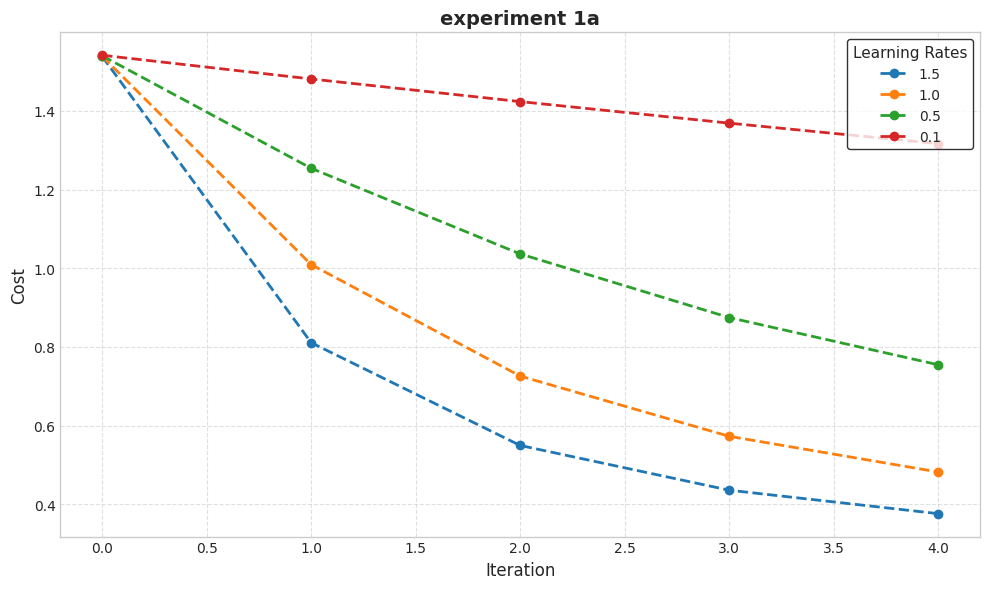

In [55]:
plot("experiment 1a", cost_functions, "Learning Rates")

In [57]:
# experiment 1b

regulirization_values = [1.5, 1.0, 0.5, 0.1, 0.01, 0.001]
nIter = 10
cost_functions_r = {}

for r in regulirization_values:
  print(f"\nwith lambda: {r}")
  normalized_data, _ , _ = normalize(data)
  _, _, history_r = train(normalized_data, nIter, 1.5, r)
  cost_functions_r[r] = history_r


with lambda: 1.5


Iteration 0: Cost = 1.6262967835912883


Iteration 1: Cost = 0.7678975662965037


Iteration 2: Cost = 0.5784106179166585


Iteration 3: Cost = 0.5255553064694247


Iteration 4: Cost = 0.5079955126411316


Iteration 5: Cost = 0.5012648359728988


Iteration 6: Cost = 0.49831327379601664


Iteration 7: Cost = 0.4968622545188199


Iteration 8: Cost = 0.4960840164821264


Iteration 9: Cost = 0.49564020258201086

with lambda: 1.0


Iteration 0: Cost = 1.6051149835491865


Iteration 1: Cost = 0.7900145939336443


Iteration 2: Cost = 0.5739422835881833


Iteration 3: Cost = 0.5030236285058087


Iteration 4: Cost = 0.47541180999394334


Iteration 5: Cost = 0.4633232581548818


Iteration 6: Cost = 0.4574753747163564


Iteration 7: Cost = 0.45439703584572894


Iteration 8: Cost = 0.45265654266083716


Iteration 9: Cost = 0.4516123067961976

with lambda: 0.5


Iteration 0: Cost = 1.5750384027698174


Iteration 1: Cost = 0.8056664977217376


Iteration 2: Cost = 0.5653284510942527


Iteration 3: Cost = 0.4737912155704451


Iteration 4: Cost = 0.4322839397560601


Iteration 5: Cost = 0.41125549746690226


Iteration 6: Cost = 0.3996096594628935


Iteration 7: Cost = 0.3927031627981648


Iteration 8: Cost = 0.3883851752851073


Iteration 9: Cost = 0.38556982439059917

with lambda: 0.1


Iteration 0: Cost = 1.5430376995157715


Iteration 1: Cost = 0.8105657091172924


Iteration 2: Cost = 0.5516381998544508


Iteration 3: Cost = 0.44060819052602934


Iteration 4: Cost = 0.3833471736241556


Iteration 5: Cost = 0.35021435096047393


Iteration 6: Cost = 0.3291658041777952


Iteration 7: Cost = 0.314802810185497


Iteration 8: Cost = 0.3044681493468409


Iteration 9: Cost = 0.2967319637539471

with lambda: 0.01


Iteration 0: Cost = 1.5347319736545808


Iteration 1: Cost = 0.8104102346374


Iteration 2: Cost = 0.5472367578307893


Iteration 3: Cost = 0.43122578731269434


Iteration 4: Cost = 0.3694969398808218


Iteration 5: Cost = 0.3325607468927619


Iteration 6: Cost = 0.30824366794105457


Iteration 7: Cost = 0.2910132289309981


Iteration 8: Cost = 0.27811996637980907


Iteration 9: Cost = 0.26807262181265085

with lambda: 0.001


Iteration 0: Cost = 1.5338777097997935


Iteration 1: Cost = 0.8103654741618613


Iteration 2: Cost = 0.5467635849721143


Iteration 3: Cost = 0.43023881506874145


Iteration 4: Cost = 0.3680386757539818


Iteration 5: Cost = 0.3306920328532708


Iteration 6: Cost = 0.3060141443061973


Iteration 7: Cost = 0.2884598975999412


Iteration 8: Cost = 0.2752710249182372


[Stage 547:==============>                                          (1 + 3) / 4]

Iteration 9: Cost = 0.2649504606618415


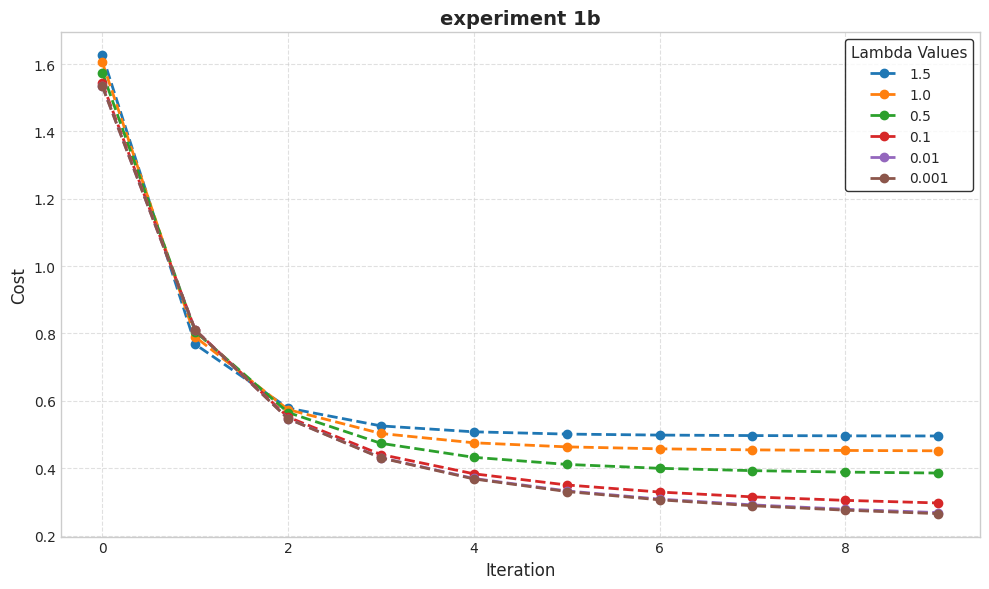

In [58]:
plot("experiment 1b", cost_functions_r, "Lambda Values")

In [78]:
# experiment 2
import sys
import time

execution_times = []
speed_up = []

# max wn_workers = 11
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

for i in range (1,4):

    number_cores = i

    conf = (
        pyspark.SparkConf()
        .setMaster('local[{}]'.format(number_cores))
    )

    sc = pyspark.SparkContext(conf=conf)
    print("number of cores: ", sc.defaultParallelism)
    
    
    # read data
    data = readFile('botnet_reduced_l.csv')

    # print(type(data))

    print("number of partitions: ", data.getNumPartitions())
    
    start_time = time.time()
    # standardize
    normalized_data, _ , _ = normalize(data)
    
    data_cached = normalized_data.cache()

    # train
    weights, bias, _ = train(normalized_data, 10, 1.5, 0.05)
    finish_time = time.time()

    execution_times.append(finish_time - start_time)
    speed_up.append(execution_times[0]/execution_times[i-1])

    sc.stop()

num_workers = list(range(1, len(execution_times)+1))

Py4JJavaError: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: org.apache.spark.SparkException: Only one SparkContext should be running in this JVM (see SPARK-2243).The currently running SparkContext was created at:
org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:829)
	at org.apache.spark.SparkContext$.$anonfun$assertNoOtherContextIsRunning$2(SparkContext.scala:2840)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.SparkContext$.assertNoOtherContextIsRunning(SparkContext.scala:2837)
	at org.apache.spark.SparkContext$.markPartiallyConstructed(SparkContext.scala:2927)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:99)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:238)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [75]:
SparkContext._active_spark_context

In [76]:
spark.stop()

In [77]:
SparkContext._active_spark_context